In [2]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.neighbors import KDTree
import folium
from folium.plugins import MarkerCluster, HeatMap
import warnings
import heapq
import scipy.cluster.hierarchy as sch
import plotly.express as px
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Mounted at /content/drive


# **Xây dựng hàm hỗ trợ**

In [3]:

def load_and_preprocess_data():
    """Load and preprocess the traffic data"""
    # Load data
    df = pd.read_csv("/content/drive/MyDrive/Khóa Luận Tốt Nghiệp/Code/train.csv",
                     index_col="_id", parse_dates=["date"])

    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())

    return df

def handle_missing_data(df):
    """Handle missing values in the dataset"""
    # Fill missing max_velocity based on street_type
    avg_max_velocity = df.groupby('street_type')['max_velocity'].mean().sort_values(ascending=False)
    velocity_dict = avg_max_velocity.to_dict()
    df['max_velocity'] = df['max_velocity'].fillna(df['street_type'].map(velocity_dict))
    df.dropna(subset=['max_velocity'], inplace=True)

    # Drop rows with missing street_name
    df.dropna(subset=['street_name'], inplace=True)

    print("Null max_velocity after filling:", df['max_velocity'].isna().sum())
    print("Null street_name after dropping:", df['street_name'].isna().sum())

    return df

def create_features(df):
    """Create new features for analysis"""
    # Select relevant columns
    cols = ["segment_id", "street_id", "s_node_id", "e_node_id", "street_name", "date", "weekday",
            "length", "max_velocity", "street_level", "street_type",
            "long_snode", "lat_snode", "long_enode", "lat_enode", "period", "LOS"]
    df = df[cols]

    # Define peak hours and special days
    peaks = ["period_6_00", "period_6_30", "period_7_00", "period_7_30",
             "period_16_00", "period_16_30", "period_17_00", "period_17_30",
             "period_18_00", "period_18_30"]

    def is_special(date):
        """Check if date is a Vietnamese holiday"""
        holidays = [(1,1), (14,2), (8,3), (30,4), (1,5), (1,6),
                    (2,9), (20,10), (20,11), (24,12), (25,12)]
        return any(date.day == day and date.month == month for day, month in holidays)

    # Create new features
    df["is_weekend"] = df["weekday"].apply(lambda x: int(x in [5, 6]))
    df["is_peak"] = df["period"].apply(lambda p: int(p in peaks))
    df["special_day"] = df["date"].apply(lambda date: int(is_special(date)))

    # Calculate segment center coordinates
    df['center_lat'] = (df['lat_snode'] + df['lat_enode']) / 2
    df['center_lng'] = (df['long_snode'] + df['long_enode']) / 2

    print("Enhanced dataset shape:", df.shape)
    print("New features added: is_weekend, is_peak, special_day, center_lat, center_lng")

    return df

def perform_eda(df):
    """Perform exploratory data analysis"""
    # Check missing values
    missing_df = pd.DataFrame({
        'missing_count': df.isnull().sum(),
        'missing_ratio': df.isnull().sum() / len(df)
    }).sort_values('missing_ratio', ascending=False)

    print("Missing values analysis:")
    print(missing_df[missing_df['missing_count'] > 0])

    # Visualize LOS distribution
    plt.figure(figsize=(12, 6))
    df['LOS'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Distribution of Level of Service (LOS)', fontsize=14, fontweight='bold')
    plt.xlabel('Level of Service')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize average speed by road type
    avg_max_velocity = df.groupby('street_type')['max_velocity'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    plt.bar(avg_max_velocity.index, avg_max_velocity.values, color='skyblue')
    plt.title('Average Speed by Road Type', fontsize=14, fontweight='bold')
    plt.xlabel('Road Type')
    plt.ylabel('Average Speed')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def prepare_clustering_features(data, feature_set='spatial'):
    """Prepare different feature sets for clustering"""
    if feature_set == 'spatial':
        features = ['center_lat', 'center_lng']
    elif feature_set == 'spatial_length':
        features = ['center_lat', 'center_lng', 'length']
    elif feature_set == 'comprehensive':
        features = ['center_lat', 'center_lng', 'length', 'max_velocity',
                   'is_weekend', 'is_peak', 'street_level']

    # Clean data
    feature_df = data[features].copy()
    feature_df = feature_df.dropna()

    # Encode categorical variables if present
    categorical_features = ['street_level'] if 'street_level' in features else []
    for col in categorical_features:
        le = LabelEncoder()
        feature_df[col] = le.fit_transform(feature_df[col].astype(str))

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)

    return scaled_features, feature_df.index, scaler

def evaluate(labels, X):
    """Return Silhouette Score (None if cluster is not valid)"""
    non_noise = labels != -1
    if len(np.unique(labels[non_noise])) < 2:
        return None

    sil = silhouette_score(X[non_noise], labels[non_noise])
    return sil

def optimize_dbscan(features, eps_range=(0.05, 1.2, 10), min_samples_list=[3, 5, 8, 12, 20]):
    """Optimize DBSCAN parameters"""
    X = StandardScaler().fit_transform(features)
    eps_vals = np.linspace(*eps_range)
    best_score, best_params, best_labels = -1, None, None
    results = []

    print("\n" + "="*60)
    print("OPTIMIZING DBSCAN")
    print("="*60)

    for eps in eps_vals:
        for ms in min_samples_list:
            labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
            sil = evaluate(labels, X)
            if sil is None:
                continue

            results.append([eps, ms, sil, len(set(labels)-{-1}), np.sum(labels==-1)])
            print(f"[eps={eps:.3f} ms={ms:2}] Sil={sil:.4f} Clu={len(set(labels)-{-1})} Noise={np.sum(labels==-1)}")

            if sil > best_score:
                best_score = sil
                best_labels = labels
                best_params = {"eps": eps, "min_samples": ms}

    return best_labels, best_params, pd.DataFrame(results,
            columns=["eps", "min_samples", "silhouette", "n_clusters", "n_noise"])

def optimize_optics(features, min_samples_list=[5, 10, 15, 25], xi_vals=[0.02, 0.05, 0.1, 0.2]):
    """Optimize OPTICS parameters"""
    X = StandardScaler().fit_transform(features)
    best_score, best_params, best_labels = -1, None, None
    results = []

    print("\n" + "="*60)
    print("OPTIMIZING OPTICS")
    print("="*60)

    for ms in min_samples_list:
        for xi in xi_vals:
            labels = OPTICS(min_samples=ms, xi=xi, cluster_method='xi').fit_predict(X)
            sil = evaluate(labels, X)
            if sil is None:
                continue

            results.append([ms, xi, sil, len(set(labels)-{-1}), np.sum(labels==-1)])
            print(f"[ms={ms:2} xi={xi:.2f}] Sil={sil:.4f} Clu={len(set(labels)-{-1})} Noise={np.sum(labels==-1)}")

            if sil > best_score:
                best_score = sil
                best_labels = labels
                best_params = {"min_samples": ms, "xi": xi}

    return best_labels, best_params, pd.DataFrame(results,
            columns=["min_samples", "xi", "silhouette", "n_clusters", "n_noise"])

def optimize_hdbscan(features, min_cluster=[5, 10, 15, 25], min_samples=[1, 2, 3, 5]):
    """Optimize HDBSCAN parameters"""
    X = StandardScaler().fit_transform(features)
    best_score, best_params, best_labels = -1, None, None
    results = []
    for mcs in min_cluster:
        for ms in min_samples:
            labels = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms).fit_predict(X)
            sil = evaluate(labels, X)
            if sil is None:
                continue
            results.append([mcs, ms, sil, len(set(labels)-{-1}), np.sum(labels==-1)])
            print(f"[mcs={mcs:2} ms={ms}] Sil={sil:.4f} Clu={len(set(labels)-{-1})} Noise={np.sum(labels==-1)}")
            if sil > best_score:
                best_score = sil
                best_labels = labels
                best_params = {"min_cluster_size": mcs, "min_samples": ms}
    return best_labels, best_params, pd.DataFrame(results,
            columns=["min_cluster_size", "min_samples", "silhouette", "n_clusters", "n_noise"])

def evaluate_model(labels, features, model_name):
    """Evaluate clustering model performance"""

    noise_ratio = np.mean(labels == -1) * 100
    n_clusters = len(set(labels) - {-1})  # chính xác hơn

    mask = labels != -1
    if n_clusters > 1 and np.sum(mask) > 1:
        sil = silhouette_score(features[mask], labels[mask])
    else:
        sil = None

    print(f"\n====== {model_name} Evaluation ======")
    print(f"Số cụm tìm được: {n_clusters}")
    print(f"Tỷ lệ nhiễu: {noise_ratio:.2f}%")
    print(f"Silhouette Score (không tính noise): {sil if sil else 'Không thể tính'}")

    return {
        'model': model_name,
        'clusters': n_clusters,
        'noise %': noise_ratio,
        'silhouette': sil
    }

def build_node_tree(df):
    """Build KDTree for efficient neighbor search"""
    nodes_df = pd.concat([
        df[['s_node_id','lat_snode','long_snode']].rename(
            columns={'s_node_id':'node','lat_snode':'lat','long_snode':'lng'}),
        df[['e_node_id','lat_enode','long_enode']].rename(
            columns={'e_node_id':'node','lat_enode':'lat','long_enode':'lng'})
    ])
    nodes_df = nodes_df.drop_duplicates('node').set_index('node')
    tree = KDTree(nodes_df[['lat','lng']].values)
    return nodes_df, tree

def get_neighbors_kdtree(node_id, nodes_df, tree, distance_threshold=0.001):
    """Get neighbors using KDTree for efficiency"""
    lat, lng = nodes_df.loc[node_id][['lat','lng']]
    idxs = tree.query_radius([[lat, lng]], r=distance_threshold)[0]
    neighbor_ids = [nodes_df.index[idx] for idx in idxs if nodes_df.index[idx] != node_id]
    return neighbor_ids

def heuristic_node(n1, n2, nodes_df):
    """Manhattan distance heuristic"""
    c1, c2 = nodes_df.loc[n1], nodes_df.loc[n2]
    return abs(c1['lat'] - c2['lat']) + abs(c1['lng'] - c2['lng'])

def calculate_cluster_congestion_weights(df, cluster_column='dbscan_cluster'):
    """Calculate congestion weights for each cluster based on LOS"""
    # LOS mapping: A (best) -> F (worst)
    los_weights = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 10}

    # Calculate average weight for each cluster
    cluster_stats = df.groupby(cluster_column).agg({
        'LOS': lambda x: np.mean([los_weights.get(los, 3) for los in x]),
        'length': 'mean',
        'max_velocity': 'mean'
    }).rename(columns={'LOS': 'congestion_weight'})

    # Normalize weights
    if cluster_stats['congestion_weight'].max() > 0:
        cluster_stats['normalized_weight'] = (
            cluster_stats['congestion_weight'] / cluster_stats['congestion_weight'].max()
        )
    else:
        cluster_stats['normalized_weight'] = 0

    # Clusters with good LOS (A,B) will have low cost, clusters with bad LOS (E,F) will have high cost
    cluster_stats['travel_cost'] = 1 + cluster_stats['normalized_weight'] * 5

    return cluster_stats['travel_cost'].to_dict()

def get_segment_cluster_info(df, node_id, cluster_column='dbscan_cluster'):
    """Get cluster information for segments containing node"""
    segments = df[(df['s_node_id'] == node_id) | (df['e_node_id'] == node_id)]
    if segments.empty:
        return -1, 'Unknown'  # Default values

    # Get most common cluster
    cluster = segments[cluster_column].mode()
    cluster = cluster.iloc[0] if not cluster.empty else -1

    return cluster, None

def a_star_with_cluster_avoidance(start_node, goal_node, nodes_df, tree, df_with_clusters, cluster_column='dbscan_cluster',
                                 distance_threshold=0.001, congestion_penalty=2.0):
    """A* pathfinding avoiding congested clusters"""

    # Calculate weights for clusters
    cluster_weights = calculate_cluster_congestion_weights(df_with_clusters, cluster_column)

    open_set = []
    heapq.heappush(open_set, (0, start_node))
    came_from = {}
    g_score = {node: float('inf') for node in nodes_df.index}
    g_score[start_node] = 0
    f_score = {node: float('inf') for node in nodes_df.index}
    f_score[start_node] = heuristic_node(start_node, goal_node, nodes_df)

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal_node:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        neighbors = get_neighbors_kdtree(current, nodes_df, tree, distance_threshold)
        for neighbor in neighbors:
            # Calculate cost based on cluster congestion
            cluster_id, _ = get_segment_cluster_info(df_with_clusters, neighbor, cluster_column)
            base_cost = 1.0

            # Apply penalty for congested clusters
            if cluster_id in cluster_weights and cluster_weights[cluster_id] > 2.0:  # Congestion threshold
                cluster_cost = cluster_weights[cluster_id] * congestion_penalty
            else:
                cluster_cost = 1.0

            total_cost = base_cost * cluster_cost

            tentative_g = g_score[current] + total_cost
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic_node(neighbor, goal_node, nodes_df)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []

def a_star_normal(start_node, goal_node, nodes_df, tree, distance_threshold=0.001):
    """Normal A* without considering congestion"""
    open_set = []
    heapq.heappush(open_set, (0, start_node))
    came_from = {}
    g_score = {node: float('inf') for node in nodes_df.index}
    g_score[start_node] = 0
    f_score = {node: float('inf') for node in nodes_df.index}
    f_score[start_node] = heuristic_node(start_node, goal_node, nodes_df)

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal_node:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        neighbors = get_neighbors_kdtree(current, nodes_df, tree, distance_threshold)
        for neighbor in neighbors:
            tentative_g = g_score[current] + 1  # Fixed cost
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic_node(neighbor, goal_node, nodes_df)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []

def evaluate_path_quality(path, nodes_df, df_with_clusters):
    """Evaluate path quality based on LOS"""
    if not path:
        return 0, 0

    total_segments = len(path) - 1
    congested_segments = 0
    total_congestion_score = 0

    los_weights = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 10}

    for i in range(len(path) - 1):
        node1, node2 = path[i], path[i + 1]
        # Find corresponding segments
        segments = df_with_clusters[
            ((df_with_clusters['s_node_id'] == node1) & (df_with_clusters['e_node_id'] == node2)) |
            ((df_with_clusters['s_node_id'] == node2) & (df_with_clusters['e_node_id'] == node1))
        ]

        if not segments.empty:
            los = segments.iloc[0]['LOS']
            congestion_score = los_weights.get(los, 3)
            total_congestion_score += congestion_score
            if los in ['E', 'F']:
                congested_segments += 1

    congestion_ratio = congested_segments / total_segments if total_segments > 0 else 0
    avg_congestion = total_congestion_score / total_segments if total_segments > 0 else 0
    return congestion_ratio, avg_congestion

def create_comparison_visualization(normal_path, cluster_path, nodes_df, algorithm_name, df_with_clusters):
    """Create comparison visualization between normal and cluster-based paths"""
    if not normal_path or not cluster_path:
        print("Cannot create comparison: missing paths")
        return None

    # Find center point for map
    center_lat, center_lng = nodes_df.loc[normal_path[0], ['lat','lng']]
    m = folium.Map(location=[center_lat, center_lng], zoom_start=14)

    # Draw normal path (red)
    normal_coords = [(nodes_df.loc[nid, 'lat'], nodes_df.loc[nid, 'lng']) for nid in normal_path]
    folium.PolyLine(normal_coords, color='red', weight=6, opacity=0.8,
                   popup='Normal Path').add_to(m)

    # Draw smart path based on clustering (blue)
    cluster_coords = [(nodes_df.loc[nid, 'lat'], nodes_df.loc[nid, 'lng']) for nid in cluster_path]
    folium.PolyLine(cluster_coords, color='blue', weight=6, opacity=0.8,
                   popup=f'Smart Path ({algorithm_name})').add_to(m)

    # Mark start and end points
    start_coord = (nodes_df.loc[normal_path[0], 'lat'], nodes_df.loc[normal_path[0], 'lng'])
    end_coord = (nodes_df.loc[normal_path[-1], 'lat'], nodes_df.loc[normal_path[-1], 'lng'])

    folium.Marker(start_coord, popup='Start Point',
                 icon=folium.Icon(color='green', icon='play', prefix='fa')).add_to(m)
    folium.Marker(end_coord, popup='End Point',
                 icon=folium.Icon(color='red', icon='stop', prefix='fa')).add_to(m)

    # Add important intermediate points
    if len(normal_path) > 10:
        # Add some intermediate points for normal path
        for i in range(1, min(5, len(normal_path)-1)):
            mid_idx = i * len(normal_path) // 5
            mid_coord = (nodes_df.loc[normal_path[mid_idx], 'lat'], nodes_df.loc[normal_path[mid_idx], 'lng'])
            folium.CircleMarker(mid_coord, radius=4, color='red', fill=True,
                              popup=f'Intermediate Point {i} (Normal)').add_to(m)

    if len(cluster_path) > 10:
        # Add some intermediate points for smart path
        for i in range(1, min(5, len(cluster_path)-1)):
            mid_idx = i * len(cluster_path) // 5
            mid_coord = (nodes_df.loc[cluster_path[mid_idx], 'lat'], nodes_df.loc[cluster_path[mid_idx], 'lng'])
            folium.CircleMarker(mid_coord, radius=4, color='blue', fill=True,
                              popup=f'Intermediate Point {i} (Smart)').add_to(m)

    # Calculate and display statistics
    normal_ratio, normal_avg = evaluate_path_quality(normal_path, nodes_df, df_with_clusters)
    cluster_ratio, cluster_avg = evaluate_path_quality(cluster_path, nodes_df, df_with_clusters)

    improvement = ((normal_avg - cluster_avg) / normal_avg * 100) if normal_avg > 0 else 0

    # Add legend
    legend_html = '''
    <div style="position: fixed;
                top: 10px; left: 10px; width: 250px; height: 200px;
                background-color: white; border:2px solid grey; z-index:9999;
                font-size:14px; padding: 10px; border-radius: 10px;
                box-shadow: 0 0 10px rgba(0,0,0,0.5);">
    <h4 style="margin-top:0; text-align:center;">LEGEND</h4>
    <p><i style="background:red; width:20px; height:3px; display:inline-block; margin-right:5px;"></i> Normal Path</p>
    <p><i style="background:blue; width:20px; height:3px; display:inline-block; margin-right:5px;"></i> Smart Path</p>
    <p><i class="fa fa-play" style="color:green; margin-right:5px;"></i> Start Point</p>
    <p><i class="fa fa-stop" style="color:red; margin-right:5px;"></i> End Point</p>
    <p>• Intermediate Points</p>
    </div>
    '''

    m.get_root().html.add_child(folium.Element(legend_html))

    return m

def create_detailed_comparison_chart(normal_results, cluster_results, algorithm_names):
    """Create detailed comparison chart between methods"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Prepare data
    methods = ['Normal'] + algorithm_names
    congestion_ratios = [normal_results[0]] + [result[0] for result in cluster_results]
    avg_congestions = [normal_results[1]] + [result[1] for result in cluster_results]

    # Chart 1: Congestion Ratio
    bars1 = ax1.bar(methods, congestion_ratios, color=['red', 'blue', 'green', 'orange'])
    ax1.set_title('CONGESTION RATIO COMPARISON', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Congestion Ratio', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    for bar, value in zip(bars1, congestion_ratios):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

    # Chart 2: Average Congestion
    bars2 = ax2.bar(methods, avg_congestions, color=['red', 'blue', 'green', 'orange'])
    ax2.set_title('AVERAGE CONGESTION COMPARISON', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average Congestion', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)

    for bar, value in zip(bars2, avg_congestions):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    # Calculate improvement percentages
    improvements = []
    for i in range(1, len(avg_congestions)):
        improvement = ((avg_congestions[0] - avg_congestions[i]) / avg_congestions[0] * 100)
        improvements.append(improvement)

    # Add improvement information
    ax2.text(0.02, 0.98, f'IMPROVEMENT:\n' + '\n'.join([f'{algo}: {imp:+.1f}%'
                                                     for algo, imp in zip(algorithm_names, improvements)]),
             transform=ax2.transAxes, va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8),
             fontsize=10)

    plt.tight_layout()
    plt.show()

    return fig

# **Tiền xử lý dữ liệu**

🚀 STARTING TRAFFIC ANALYSIS PIPELINE

📊 STEP 1: Loading and preprocessing data...
Dataset shape: (33441, 17)

First 5 rows:
     segment_id       date  weekday        period LOS  s_node_id   e_node_id  \
_id                                                                            
0            26 2021-04-16        4   period_0_30   A  366428456   366416066   
1            33 2020-08-02        6  period_23_30   C  366469460  3792257828   
2            33 2020-08-03        0   period_0_00   D  366469460  3792257828   
3            67 2021-03-09        1   period_9_30   B  366403668  5755066033   
4            67 2021-03-23        1   period_9_30   B  366403668  5755066033   

     length  street_id  max_velocity  street_level    street_name street_type  \
_id                                                                             
0       116   32575820           NaN             4  Nguyễn Văn Bá    tertiary   
1        26   32575862           NaN             3     Đường số 5   seco

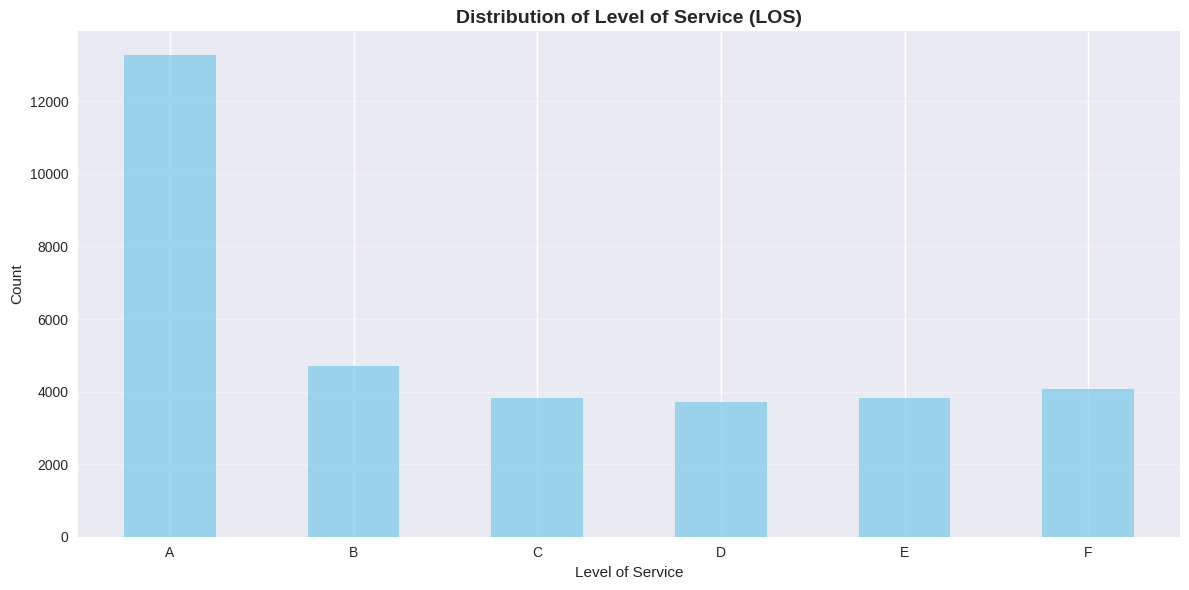

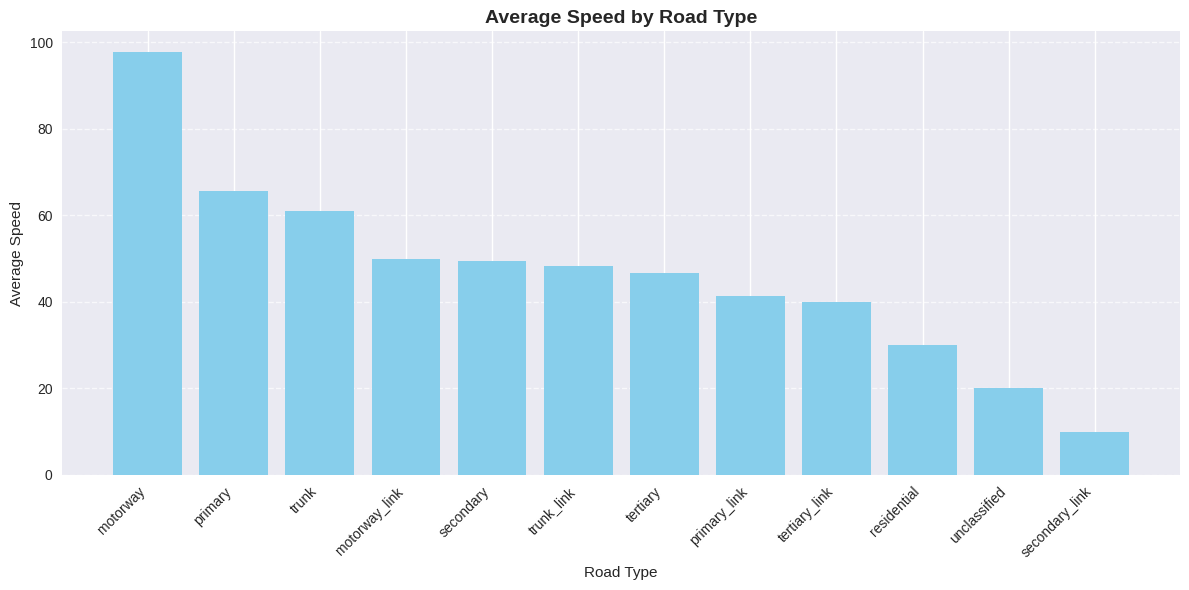


🔧 STEP 3: Preparing clustering features...
>> TRAIN SET: (33393, 7) samples

🎯 STEP 4: Optimizing clustering algorithms...


In [4]:

    """Main execution function"""
    print("STARTING TRAFFIC ANALYSIS PIPELINE")
    print("="*60)

    # 1. Load and preprocess data
    print("\nSTEP 1: Loading and preprocessing data...")
    df = load_and_preprocess_data()
    df = handle_missing_data(df)
    df = create_features(df)
    print(df)

    # 2. Exploratory Data Analysis
    print("\nSTEP 2: Performing exploratory data analysis...")
    perform_eda(df)

    # 3. Prepare clustering features
    print("\nSTEP 3: Preparing clustering features...")
    comprehensive_features, comp_idx, comp_scaler = prepare_clustering_features(df, 'comprehensive')
    print(f">> TRAIN SET: {comprehensive_features.shape} samples")

    # 4. Optimize clustering algorithms
    print("\nSTEP 4: Optimizing clustering algorithms...")




# **Tìm tham số tối ưu cho thuật toán**

In [ ]:
    # DBSCAN Optimization
    db_labels, db_param, db_log = optimize_dbscan(
        features=comprehensive_features,
        eps_range=(0.06, 0.09, 4),
        min_samples_list=[5, 6, 7, 8]
    )
    print("\n BEST DBSCAN PARAMS →", db_param)

    # OPTICS Optimization
    op_labels, op_param, op_log = optimize_optics(
        features=comprehensive_features,
        min_samples_list=[5, 10, 15, 25],
        xi_vals=[0.02, 0.05, 0.1, 0.2]
    )
    print("\n BEST OPTICS PARAMS →", op_param)

    # HDBSCAN Optimization
    hb_labels, hb_param, hb_log = optimize_hdbscan(
        features=comprehensive_features,
        min_cluster=[5, 10, 15, 25],
        min_samples=[1, 2, 3, 5]
    )
    print("\n BEST HDBSCAN PARAMS →", hb_param)

    # 5. Apply clustering with optimized parameters
    print("\n STEP 5: Applying clustering algorithms...")

    best_parameters_comprehensive = {
        'dbscan_params': db_param,
        'optics_params': op_param,
        'hdbscan_params': hb_param
    }


OPTIMIZING DBSCAN
[eps=0.060 ms= 5] Sil=0.7318 Clu=1756 Noise=12458
[eps=0.060 ms= 6] Sil=0.7310 Clu=1433 Noise=14214
[eps=0.060 ms= 7] Sil=0.7444 Clu=1171 Noise=16042
[eps=0.060 ms= 8] Sil=0.7499 Clu=989 Noise=17478
[eps=0.070 ms= 5] Sil=0.6452 Clu=1655 Noise=11207
[eps=0.070 ms= 6] Sil=0.6416 Clu=1366 Noise=12791
[eps=0.070 ms= 7] Sil=0.6479 Clu=1121 Noise=14499
[eps=0.070 ms= 8] Sil=0.6587 Clu=953 Noise=15839
[eps=0.080 ms= 5] Sil=0.5227 Clu=1541 Noise=9980
[eps=0.080 ms= 6] Sil=0.5295 Clu=1275 Noise=11474
[eps=0.080 ms= 7] Sil=0.5390 Clu=1066 Noise=12935
[eps=0.080 ms= 8] Sil=0.5469 Clu=912 Noise=14237
[eps=0.090 ms= 5] Sil=0.4690 Clu=1499 Noise=8967
[eps=0.090 ms= 6] Sil=0.4694 Clu=1249 Noise=10385
[eps=0.090 ms= 7] Sil=0.4861 Clu=1048 Noise=11781
[eps=0.090 ms= 8] Sil=0.5033 Clu=903 Noise=13080

 BEST DBSCAN PARAMS → {'eps': np.float64(0.06), 'min_samples': 8}

OPTIMIZING OPTICS
[ms= 5 xi=0.02] Sil=0.7452 Clu=2902 Noise=6445
[ms= 5 xi=0.05] Sil=0.7639 Clu=2838 Noise=7208
[ms= 5 

In [ ]:
print(best_parameters_comprehensive)

{'dbscan_params': {'eps': np.float64(0.06), 'min_samples': 8}, 'optics_params': {'min_samples': 5, 'xi': 0.2}, 'hdbscan_params': {'min_cluster_size': 5, 'min_samples': 5}}


# **Huấn luyện với tham số tối ưu**

In [ ]:

    # Apply clustering algorithms
    df['dbscan_cluster'] = DBSCAN(**best_parameters_comprehensive['dbscan_params']).fit_predict(comprehensive_features)
    df['optics_cluster'] = OPTICS(**best_parameters_comprehensive['optics_params'], cluster_method='xi').fit_predict(comprehensive_features)
    df['hdbscan_cluster'] = hdbscan.HDBSCAN(**best_parameters_comprehensive['hdbscan_params']).fit_predict(comprehensive_features)

    # Evaluate models
    print("\n📋 STEP 6: Evaluating clustering models...")
    dbscan_result = evaluate_model(df['dbscan_cluster'], comprehensive_features, "DBSCAN")
    optics_result = evaluate_model(df['optics_cluster'], comprehensive_features, "OPTICS")
    hdbscan_result = evaluate_model(df['hdbscan_cluster'], comprehensive_features, "HDBSCAN")


📋 STEP 6: Evaluating clustering models...

====== DBSCAN Evaluation ======
Số cụm tìm được: 989
Tỷ lệ nhiễu: 52.34%
Silhouette Score (không tính noise): 0.7498923338068826

====== OPTICS Evaluation ======
Số cụm tìm được: 2445
Tỷ lệ nhiễu: 34.53%
Silhouette Score (không tính noise): 0.8604405027638241

====== HDBSCAN Evaluation ======
Số cụm tìm được: 2311
Tỷ lệ nhiễu: 22.42%
Silhouette Score (không tính noise): 0.738998038001679


# **Test**


🗺️ STEP 7: Performing pathfinding analysis...
Pathfinding from 5816921541 to 5772608671

Finding normal path...
Normal path: 52 nodes
Congestion ratio: 7.84%, Avg congestion: 0.65

Finding smart path with DBSCAN...
DBSCAN path: 53 nodes
Congestion ratio: 1.92%, Avg congestion: 0.35
Creating comparison visualization for DBSCAN...


Comparison map for DBSCAN displayed!

Finding smart path with OPTICS...
OPTICS path: 54 nodes
Congestion ratio: 3.77%, Avg congestion: 0.49
Creating comparison visualization for OPTICS...


Comparison map for OPTICS displayed!

Finding smart path with HDBSCAN...
HDBSCAN path: 53 nodes
Congestion ratio: 1.92%, Avg congestion: 0.35
Creating comparison visualization for HDBSCAN...


Comparison map for HDBSCAN displayed!

Creating overall comparison chart...


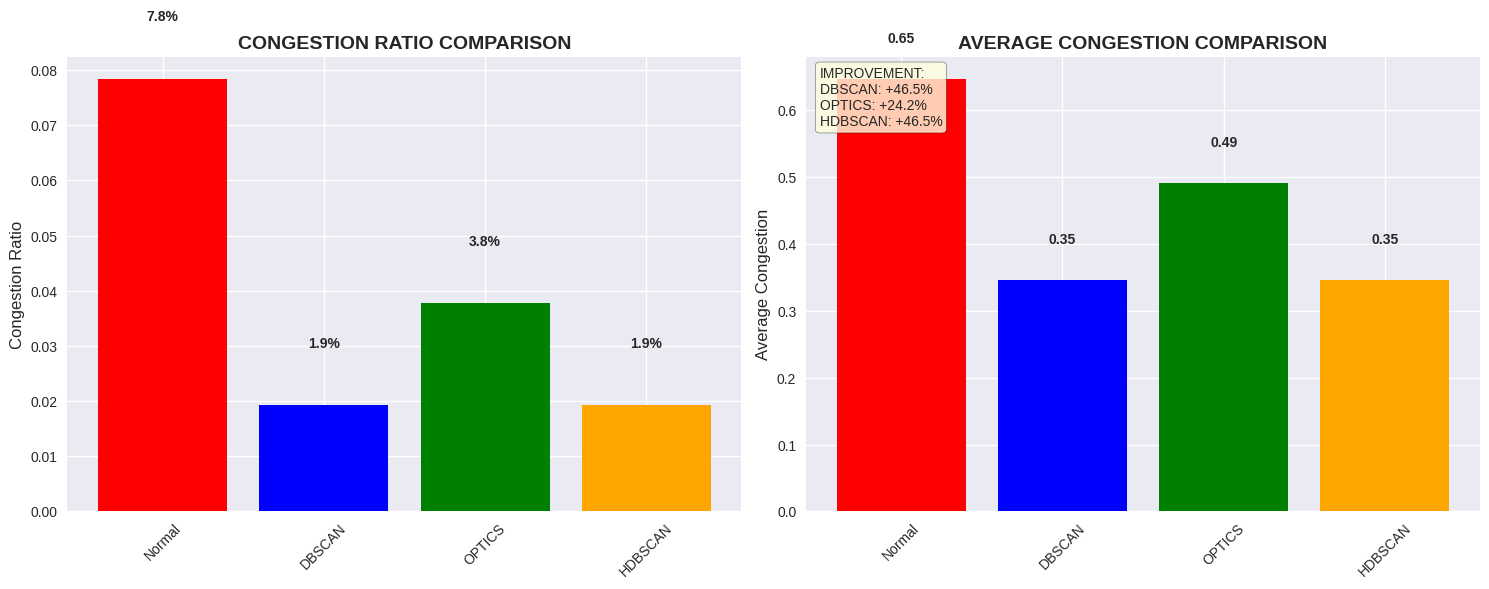


FINAL COMPARISON SUMMARY
Best method: DBSCAN
Average congestion:
  - Normal: 0.65
  - DBSCAN: 0.35
  - Improvement: +46.5%
Congested segment ratio:
  - Normal: 7.8%
  - DBSCAN: 1.9%

✅ Analysis completed successfully!


In [ ]:
    # 7. Pathfinding and comparison
    print("\n🗺️ STEP 7: Performing pathfinding analysis...")

    # Build node tree
    nodes_df, tree = build_node_tree(df)

    # Define start and end nodes
    start_node = 5816921541
    end_node = 5772608671

    print(f"Pathfinding from {start_node} to {end_node}")

    # Find normal path
    print("\nFinding normal path...")
    normal_path = a_star_normal(start_node, end_node, nodes_df, tree)
    normal_congestion_ratio, normal_avg_congestion = evaluate_path_quality(normal_path, nodes_df, df)
    print(f"Normal path: {len(normal_path)} nodes")
    print(f"Congestion ratio: {normal_congestion_ratio:.2%}, Avg congestion: {normal_avg_congestion:.2f}")

    # Find smart paths for each algorithm
    clustering_algorithms = [
        ('dbscan_cluster', 'DBSCAN'),
        ('optics_cluster', 'OPTICS'),
        ('hdbscan_cluster', 'HDBSCAN')
    ]

    cluster_paths = {}
    cluster_results = {}

    for cluster_col, algo_name in clustering_algorithms:
        print(f"\nFinding smart path with {algo_name}...")
        cluster_path = a_star_with_cluster_avoidance(
            start_node, end_node, nodes_df, tree, df, cluster_col
        )

        if cluster_path:
            cluster_paths[algo_name] = cluster_path
            congestion_ratio, avg_congestion = evaluate_path_quality(cluster_path, nodes_df, df)
            cluster_results[algo_name] = (congestion_ratio, avg_congestion)

            print(f"{algo_name} path: {len(cluster_path)} nodes")
            print(f"Congestion ratio: {congestion_ratio:.2%}, Avg congestion: {avg_congestion:.2f}")

            # Create comparison visualization for each algorithm
            print(f"Creating comparison visualization for {algo_name}...")
            m = create_comparison_visualization(normal_path, cluster_path, nodes_df, algo_name, df)
            if m:
                display(m)
                print(f"Comparison map for {algo_name} displayed!")
        else:
            print(f"{algo_name}: No path found")

    # Create overall comparison chart
    print("\nCreating overall comparison chart...")
    algorithm_names = [name for _, name in clustering_algorithms if name in cluster_results]
    cluster_results_list = [cluster_results[name] for name in algorithm_names]

    if cluster_results_list:
        fig = create_detailed_comparison_chart(
            (normal_congestion_ratio, normal_avg_congestion),
            cluster_results_list,
            algorithm_names
        )

    # Final summary
    print("\n" + "="*60)
    print("FINAL COMPARISON SUMMARY")
    print("="*60)

    if cluster_results:
        best_algo = min(cluster_results.keys(), key=lambda x: cluster_results[x][1])
        best_ratio, best_avg = cluster_results[best_algo]
        improvement = ((normal_avg_congestion - best_avg) / normal_avg_congestion * 100)

        print(f"Best method: {best_algo}")
        print(f"Average congestion:")
        print(f"  - Normal: {normal_avg_congestion:.2f}")
        print(f"  - {best_algo}: {best_avg:.2f}")
        print(f"  - Improvement: {improvement:+.1f}%")
        print(f"Congested segment ratio:")
        print(f"  - Normal: {normal_congestion_ratio:.1%}")
        print(f"  - {best_algo}: {best_ratio:.1%}")

    print("\n✅ Analysis completed successfully!")

🚀 BẮT ĐẦU ĐÁNH GIÁ TOÀN DIỆN HỆ THỐNG

📊 Bước 1: Chuẩn bị dữ liệu...

🎯 Bước 2: Đánh giá hiệu suất clustering...

🔍 Đánh giá cho khoảng cụm: 0-500

📊 Đang chạy DBSCAN...
✅ DBSCAN - Khoảng 0-500:
   • Số cụm: 275
   • Điểm nhiễu: 27163 (81.34%)
   • Silhouette Score: 0.8789
   • Thời gian: 3.5828s
   • Trong khoảng mục tiêu: ✅

📊 Đang chạy OPTICS...
✅ OPTICS - Khoảng 0-500:
   • Số cụm: 371
   • Điểm nhiễu: 16537 (49.52%)
   • Silhouette Score: 0.5805
   • Thời gian: 88.2440s
   • Trong khoảng mục tiêu: ✅

📊 Đang chạy HDBSCAN...
✅ HDBSCAN - Khoảng 0-500:
   • Số cụm: 379
   • Điểm nhiễu: 10206 (30.56%)
   • Silhouette Score: 0.4239
   • Thời gian: 6.3640s
   • Trong khoảng mục tiêu: ✅

🔍 Đánh giá cho khoảng cụm: 500-1000

📊 Đang chạy DBSCAN...
✅ DBSCAN - Khoảng 500-1000:
   • Số cụm: 953
   • Điểm nhiễu: 15839 (47.43%)
   • Silhouette Score: 0.6587
   • Thời gian: 2.0375s
   • Trong khoảng mục tiêu: ✅

📊 Đang chạy OPTICS...
✅ OPTICS - Khoảng 500-1000:
   • Số cụm: 627
   • Điểm nhiễu: 1

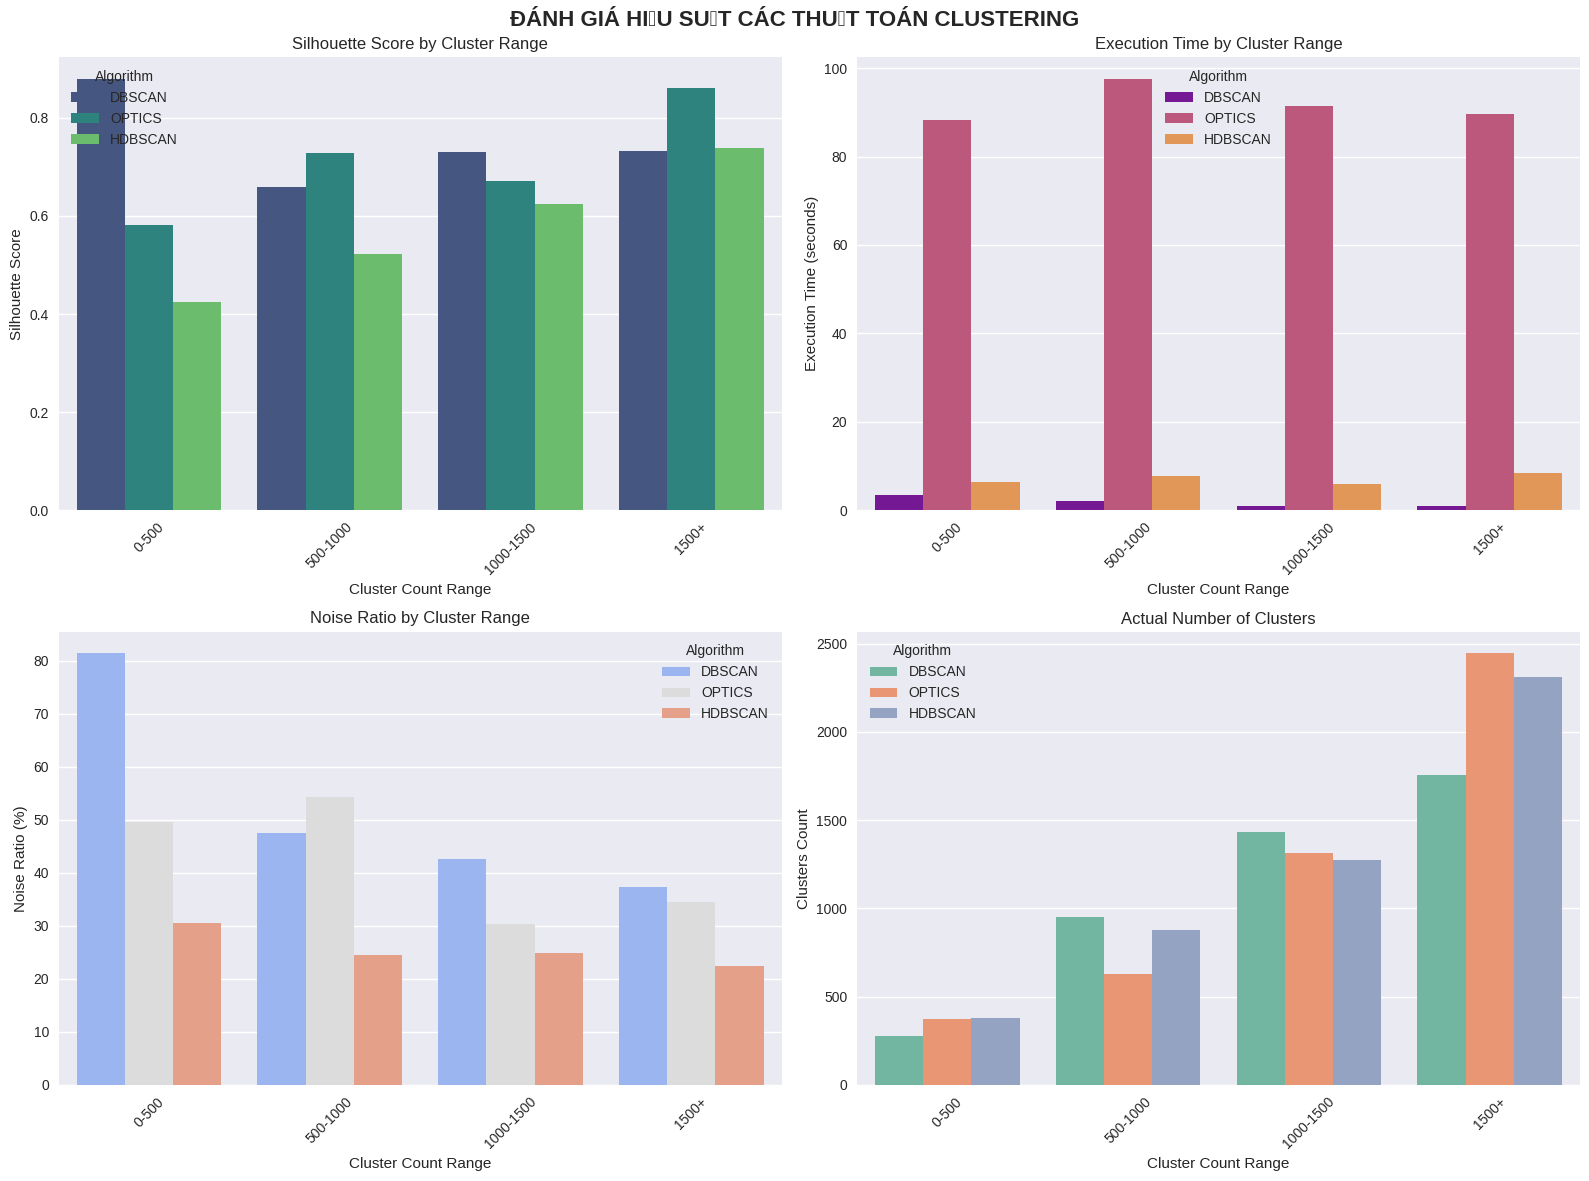


BẢNG SO SÁNH TỔNG QUAN CÁC THUẬT TOÁN CLUSTERING
          silhouette_score         execution_time         noise_ratio  \
                      mean     std           mean     std        mean   
algorithm                                                               
DBSCAN              0.7501  0.0925         1.8509  1.2747     52.1621   
HDBSCAN             0.5772  0.1353         7.1470  1.1460     25.6072   
OPTICS              0.7099  0.1173        91.7038  4.1116     42.1915   

                   n_clusters  
               std      count  
algorithm                      
DBSCAN     19.8887          4  
HDBSCAN     3.4811          4  
OPTICS     11.5470          4  

🛣️  Bước 4: Đánh giá hiệu suất pathfinding...

🚀 ĐÁNH GIÁ HIỆU SUẤT PATHFINDING VỚI CÁC CLUSTERING

📍 Tìm đường đi thông thường...

📍 Tìm đường đi với DBSCAN...
   ✅ Cải thiện: +46.5%

📍 Tìm đường đi với OPTICS...
   ✅ Cải thiện: +24.2%

📍 Tìm đường đi với HDBSCAN...
   ✅ Cải thiện: +46.5%

📋 Bước 5: Tạo báo cáo tổng

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, OPTICS
import hdbscan

def evaluate_clustering_quality(df, features_comp, cluster_ranges):

    results = []

    # Các bộ tham số để thử nghiệm cho từng khoảng cụm
    parameter_sets = {
        '0-500': {
            'dbscan': {'eps': 0.05, 'min_samples': 15},
            'optics': {'min_samples': 25, 'xi': 0.02},
            'hdbscan': {'min_cluster_size': 25, 'min_samples': 5}
        },
        '500-1000': {
            'dbscan': {'eps': 0.07, 'min_samples': 8},
            'optics': {'min_samples': 15, 'xi': 0.1},
            'hdbscan': {'min_cluster_size': 15, 'min_samples': 3}
        },
        '1000-1500': {
            'dbscan': {'eps': 0.06, 'min_samples': 6},
            'optics': {'min_samples': 10, 'xi': 0.02},
            'hdbscan': {'min_cluster_size': 10, 'min_samples': 5}
        },
        '1500+': {
            'dbscan': {'eps': 0.06, 'min_samples': 5},
            'optics': {'min_samples': 5, 'xi': 0.2},
            'hdbscan': {'min_cluster_size': 5, 'min_samples': 5}
        }
    }

    algorithms = [
        ('DBSCAN', DBSCAN, 'dbscan'),
        ('OPTICS', OPTICS, 'optics'),
        ('HDBSCAN', hdbscan.HDBSCAN, 'hdbscan')
    ]

    for cluster_range in cluster_ranges:
        range_name = f"{cluster_range[0]}-{cluster_range[1]}" if cluster_range[1] != float('inf') else "1500+"
        print(f"\nĐánh giá cho khoảng cụm: {range_name}")
        print("="*50)

        for algo_name, algo_class, algo_key in algorithms:
            print(f"\nĐang chạy {algo_name}...")

            # Lấy tham số tối ưu cho khoảng cụm này
            params = parameter_sets[range_name][algo_key]

            # Thêm tham số đặc biệt cho từng thuật toán
            if algo_name == 'OPTICS':
                params = params.copy()
                params['cluster_method'] = 'xi'

            # Đo thời gian thực thi
            start_time = time.time()

            if algo_name == 'HDBSCAN':
                model = algo_class(**params)
                labels = model.fit_predict(features_comp)
            else:
                model = algo_class(**params)
                labels = model.fit_predict(features_comp)

            execution_time = time.time() - start_time

            # Tính các chỉ số đánh giá
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_points = np.sum(labels == -1)
            noise_ratio = (noise_points / len(labels)) * 100

            # Tính Silhouette Score (chỉ tính nếu có ít nhất 2 cụm)
            if n_clusters > 1:
                # Chỉ lấy các điểm không phải nhiễu để tính silhouette
                valid_mask = labels != -1
                if len(set(labels[valid_mask])) > 1:
                    silhouette = silhouette_score(features_comp[valid_mask], labels[valid_mask])
                else:
                    silhouette = None
            else:
                silhouette = None

            # Kiểm tra xem số cụm có nằm trong khoảng mong muốn không
            in_range = cluster_range[0] <= n_clusters <= cluster_range[1]

            # Lưu kết quả
            result = {
                'algorithm': algo_name,
                'cluster_range': range_name,
                'n_clusters': n_clusters,
                'noise_points': noise_points,
                'noise_ratio': noise_ratio,
                'silhouette_score': silhouette,
                'execution_time': execution_time,
                'in_target_range': in_range,
                'parameters': params
            }

            results.append(result)

            # In kết quả
            print(f"✅ {algo_name} - Khoảng {range_name}:")
            print(f"   • Số cụm: {n_clusters}")
            print(f"   • Điểm nhiễu: {noise_points} ({noise_ratio:.2f}%)")
            # Fix: Handle None for silhouette score formatting
            print(f"   • Silhouette Score: {f'{silhouette:.4f}' if silhouette is not None else 'N/A'}")
            print(f"   • Thời gian: {execution_time:.4f}s")
            print(f"   • Trong khoảng mục tiêu: {'✅' if in_range else '❌'}")

    return pd.DataFrame(results)

def visualize_clustering_evaluation(results_df):
    """Trực quan hóa kết quả đánh giá clustering"""

    # Lọc chỉ các kết quả trong khoảng mục tiêu
    valid_results = results_df[results_df['in_target_range'] == True]

    if len(valid_results) == 0:
        print("⚠️ Không có kết quả nào trong khoảng mục tiêu!")
        return

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ĐÁNH GIÁ HIỆU SUẤT CÁC THUẬT TOÁN CLUSTERING', fontsize=16, fontweight='bold')

    # 1. Silhouette Score
    ax1 = axes[0, 0]
    silhouette_data = valid_results[valid_results['silhouette_score'].notna()]
    if not silhouette_data.empty:
        sns.barplot(data=silhouette_data, x='cluster_range', y='silhouette_score',
                    hue='algorithm', ax=ax1, palette='viridis')
        ax1.set_title('Silhouette Score by Cluster Range')
        ax1.set_ylabel('Silhouette Score')
        ax1.set_xlabel('Cluster Count Range')
        ax1.legend(title='Algorithm')
        ax1.tick_params(axis='x', rotation=45)

    # 2. Execution Time
    ax2 = axes[0, 1]
    sns.barplot(data=valid_results, x='cluster_range', y='execution_time',
                hue='algorithm', ax=ax2, palette='plasma')
    ax2.set_title('Execution Time by Cluster Range')
    ax2.set_ylabel('Execution Time (seconds)')
    ax2.set_xlabel('Cluster Count Range')
    ax2.legend(title='Algorithm')
    ax2.tick_params(axis='x', rotation=45)

    # 3. Noise Ratio
    ax3 = axes[1, 0]
    sns.barplot(data=valid_results, x='cluster_range', y='noise_ratio',
                hue='algorithm', ax=ax3, palette='coolwarm')
    ax3.set_title('Noise Ratio by Cluster Range')
    ax3.set_ylabel('Noise Ratio (%)')
    ax3.set_xlabel('Cluster Count Range')
    ax3.legend(title='Algorithm')
    ax3.tick_params(axis='x', rotation=45)

    # 4. Actual Number of Clusters
    ax4 = axes[1, 1]
    sns.barplot(data=valid_results, x='cluster_range', y='n_clusters',
                hue='algorithm', ax=ax4, palette='Set2')
    ax4.set_title('Actual Number of Clusters')
    ax4.set_ylabel('Clusters Count')
    ax4.set_xlabel('Cluster Count Range')
    ax4.legend(title='Algorithm')
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


    # Tạo bảng so sánh tổng quan
    print("\n" + "="*80)
    print("BẢNG SO SÁNH TỔNG QUAN CÁC THUẬT TOÁN CLUSTERING")
    print("="*80)

    summary_stats = valid_results.groupby('algorithm').agg({
        'silhouette_score': ['mean', 'std'],
        'execution_time': ['mean', 'std'],
        'noise_ratio': ['mean', 'std'],
        'n_clusters': 'count'
    }).round(4)

    print(summary_stats)

def evaluate_pathfinding_performance(df, cluster_columns, nodes_df, tree):
    """
    Đánh giá hiệu suất pathfinding với các clustering khác nhau
    """

    start_node = 5816921541
    end_node = 5772608671

    path_results = []

    print("\n🚀 ĐÁNH GIÁ HIỆU SUẤT PATHFINDING VỚI CÁC CLUSTERING")
    print("="*60)

    # Đường đi thông thường (baseline)
    print("\n📍 Tìm đường đi thông thường...")
    start_time = time.time()
    normal_path = a_star_normal(start_node, end_node, nodes_df, tree)
    normal_time = time.time() - start_time
    normal_ratio, normal_avg = evaluate_path_quality(normal_path, nodes_df, df)

    path_results.append({
        'algorithm': 'NORMAL',
        'path_length': len(normal_path),
        'execution_time': normal_time,
        'congestion_ratio': normal_ratio,
        'avg_congestion': normal_avg,
        'n_clusters': 0
    })

    # Đường đi với các clustering
    for cluster_col, algo_name in cluster_columns:
        print(f"\n📍 Tìm đường đi với {algo_name}...")

        # Lấy số cụm
        n_clusters = len(df[df[cluster_col] != -1][cluster_col].unique())

        start_time = time.time()
        cluster_path = a_star_with_cluster_avoidance(
            start_node, end_node, nodes_df, tree, df, cluster_col
        )
        cluster_time = time.time() - start_time

        if cluster_path:
            cluster_ratio, cluster_avg = evaluate_path_quality(cluster_path, nodes_df, df)
            improvement = ((normal_avg - cluster_avg) / normal_avg * 100) if normal_avg > 0 else 0

            path_results.append({
                'algorithm': algo_name,
                'path_length': len(cluster_path),
                'execution_time': cluster_time,
                'congestion_ratio': cluster_ratio,
                'avg_congestion': cluster_avg,
                'improvement': improvement,
                'n_clusters': n_clusters
            })

            print(f"   ✅ Cải thiện: {improvement:+.1f}%")
        else:
            print(f"   ❌ Không tìm thấy đường đi")

    return pd.DataFrame(path_results)

def create_comprehensive_report(clustering_results, pathfinding_results):
    """Tạo báo cáo tổng hợp toàn diện"""

    print("\n" + "="*100)
    print("📊 BÁO CÁO TỔNG HỢP ĐÁNH GIÁ HỆ THỐNG")
    print("="*100)

    # Phân tích clustering
    print("\n1. PHÂN TÍCH HIỆU SUẤT CLUSTERING")
    print("-" * 50)

    best_silhouette = clustering_results.loc[clustering_results['silhouette_score'].idxmax()]
    fastest_clustering = clustering_results.loc[clustering_results['execution_time'].idxmin()]
    lowest_noise = clustering_results.loc[clustering_results['noise_ratio'].idxmin()]

    print(f"🎯 Thuật toán có Silhouette Score tốt nhất:")
    print(f"   • {best_silhouette['algorithm']} - {best_silhouette['silhouette_score']:.4f}")
    print(f"   • Khoảng cụm: {best_silhouette['cluster_range']}")
    print(f"   • Số cụm: {best_silhouette['n_clusters']}")

    print(f"\n⚡ Thuật toán nhanh nhất:")
    print(f"   • {fastest_clustering['algorithm']} - {fastest_clustering['execution_time']:.4f}s")

    print(f"\n🧹 Thuật toán có ít nhiễu nhất:")
    print(f"   • {lowest_noise['algorithm']} - {lowest_noise['noise_ratio']:.2f}%")

    # Phân tích pathfinding
    print("\n2. PHÂN TÍCH HIỆU SUẤT PATHFINDING")
    print("-" * 50)

    if len(pathfinding_results) > 1:
        best_improvement = pathfinding_results.loc[
            pathfinding_results['improvement'].idxmax() if 'improvement' in pathfinding_results.columns else 0
        ]

        print(f"🛣️  Đường đi thông thường:")
        normal_result = pathfinding_results[pathfinding_results['algorithm'] == 'NORMAL'].iloc[0]
        print(f"   • Độ ùn tắc TB: {normal_result['avg_congestion']:.2f}")
        print(f"   • Thời gian: {normal_result['execution_time']:.4f}s")

        print(f"\n🚀 Thuật toán cải thiện tốt nhất:")
        print(f"   • {best_improvement['algorithm']} - {best_improvement['improvement']:+.1f}%")
        print(f"   • Độ ùn tắc TB: {best_improvement['avg_congestion']:.2f}")
        print(f"   • Số cụm sử dụng: {best_improvement['n_clusters']}")

    # Đề xuất
    print("\n3. ĐỀ XUẤT")
    print("-" * 50)

    # Tìm thuật toán cân bằng tốt nhất
    clustering_results['composite_score'] = (
        clustering_results['silhouette_score'].fillna(0) * 0.4 +
        (1 - clustering_results['execution_time'] / clustering_results['execution_time'].max()) * 0.3 +
        (1 - clustering_results['noise_ratio'] / 100) * 0.3
    )

    best_overall = clustering_results.loc[clustering_results['composite_score'].idxmax()]

    print(f"🏆 Đề xuất thuật toán clustering tổng thể tốt nhất:")
    print(f"   • {best_overall['algorithm']}")
    print(f"   • Khoảng cụm: {best_overall['cluster_range']}")
    print(f"   • Composite Score: {best_overall['composite_score']:.4f}")
    print(f"   • Tham số: {best_overall['parameters']}")

# THỰC THI CHÍNH
def run_comprehensive_evaluation():
    """Chạy đánh giá toàn diện hệ thống"""

    print("🚀 BẮT ĐẦU ĐÁNH GIÁ TOÀN DIỆN HỆ THỐNG")
    print("="*60)

    # 1. Chuẩn bị dữ liệu
    print("\n📊 Bước 1: Chuẩn bị dữ liệu...")
    features_comp, _, _ = prepare_clustering_features(df, 'comprehensive')

    # 2. Định nghĩa các khoảng cụm
    cluster_ranges = [
        (0, 500),
        (500, 1000),
        (1000, 1500),
        (1500, float('inf'))
    ]

    # 3. Đánh giá clustering
    print("\n🎯 Bước 2: Đánh giá hiệu suất clustering...")
    clustering_results = evaluate_clustering_quality(df, features_comp, cluster_ranges)

    # 4. Trực quan hóa kết quả clustering
    print("\n📈 Bước 3: Trực quan hóa kết quả clustering...")
    visualize_clustering_evaluation(clustering_results)

    # 5. Đánh giá pathfinding
    print("\n🛣️  Bước 4: Đánh giá hiệu suất pathfinding...")
    nodes_df, tree = build_node_tree(df)
    cluster_columns = [
        ('dbscan_cluster', 'DBSCAN'),
        ('optics_cluster', 'OPTICS'),
        ('hdbscan_cluster', 'HDBSCAN')
    ]

    pathfinding_results = evaluate_pathfinding_performance(df, cluster_columns, nodes_df, tree)

    # 6. Báo cáo tổng hợp
    print("\n📋 Bước 5: Tạo báo cáo tổng hợp...")
    create_comprehensive_report(clustering_results, pathfinding_results)

    print("\n✅ HOÀN THÀNH ĐÁNH GIÁ TOÀN DIỆN!")

    return clustering_results, pathfinding_results

# Chạy đánh giá
if __name__ == "__main__":
    clustering_results, pathfinding_results = run_comprehensive_evaluation()

In [ ]:
import random
import time
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict

def generate_test_scenarios(nodes_df, num_scenarios=5, min_distance=0.001, max_distance=0.01):
    """
    Tạo các kịch bản thử nghiệm với điểm đầu và điểm cuối ngẫu nhiên

    Parameters:
    -----------
    nodes_df : DataFrame
        DataFrame chứa thông tin các node
    num_scenarios : int
        Số lượng kịch bản thử nghiệm
    min_distance : float
        Khoảng cách tối thiểu giữa start và end
    max_distance : float
        Khoảng cách tối đa giữa start và end
    """

    node_ids = nodes_df.index.tolist()
    scenarios = []

    for i in range(num_scenarios):
        attempts = 0
        while attempts < 100:  # Giới hạn số lần thử
            start_node = random.choice(node_ids)
            end_node = random.choice(node_ids)

            if start_node != end_node:
                # Tính khoảng cách giữa start và end
                start_coord = nodes_df.loc[start_node][['lat', 'lng']].values
                end_coord = nodes_df.loc[end_node][['lat', 'lng']].values

                distance = np.sqrt(np.sum((start_coord - end_coord) ** 2))

                if min_distance <= distance <= max_distance:
                    scenarios.append((start_node, end_node))
                    break

            attempts += 1

    return scenarios

def find_ground_truth_path(start_node, end_node, nodes_df, tree, distance_threshold=0.0005):
    """
    Tìm đường đi thực tế (ground truth) sử dụng A* với khoảng cách nhỏ
    để có đường đi chi tiết nhất
    """
    return a_star_normal(start_node, end_node, nodes_df, tree, distance_threshold)

def evaluate_path_accuracy(ground_truth_path, detected_path, nodes_df):
    """
    Đánh giá độ chính xác của đường đi phát hiện so với đường đi thực tế

    Parameters:
    -----------
    ground_truth_path : list
        Đường đi thực tế
    detected_path : list
        Đường đi được phát hiện bởi thuật toán
    nodes_df : DataFrame
        Thông tin các node
    """

    if not detected_path:
        return {
            'actual_nodes': len(ground_truth_path),
            'detected_nodes': 0,
            'missed_nodes': len(ground_truth_path),
            'correct_nodes': 0,
            'wrong_nodes': 0
        }

    # Chuyển đổi đường đi thành tập hợp để so sánh
    ground_truth_set = set(ground_truth_path)
    detected_set = set(detected_path)

    # Tính các chỉ số
    actual_nodes = len(ground_truth_path)
    detected_nodes = len(detected_path)
    missed_nodes = len(ground_truth_set - detected_set)
    correct_nodes = len(ground_truth_set & detected_set)
    wrong_nodes = len(detected_set - ground_truth_set)

    return {
        'actual_nodes': actual_nodes,
        'detected_nodes': detected_nodes,
        'missed_nodes': missed_nodes,
        'correct_nodes': correct_nodes,
        'wrong_nodes': wrong_nodes
    }

def run_hdbscan_test_scenarios(df, nodes_df, tree, num_scenarios=5):
    """
    Chạy thử nghiệm với HDBSCAN theo các kịch bản

    Parameters:
    -----------
    df : DataFrame
        Dữ liệu với clustering results
    nodes_df : DataFrame
        Thông tin các node
    tree : KDTree
        Cây không gian cho tìm kiếm lân cận
    num_scenarios : int
        Số lượng kịch bản thử nghiệm
    """

    print("🚀 BẮT ĐẦU THỬ NGHIỆM HDBSCAN VỚI CÁC KỊCH BẢN")
    print("="*60)

    # Tạo các kịch bản thử nghiệm
    scenarios = generate_test_scenarios(nodes_df, num_scenarios)
    print(f"✅ Đã tạo {len(scenarios)} kịch bản thử nghiệm")

    results = []

    for i, (start_node, end_node) in enumerate(scenarios, 1):
        print(f"\n📋 Kịch bản {i}: Từ {start_node} đến {end_node}")
        print("-" * 40)

        # Tìm đường đi thực tế (ground truth)
        print("📍 Tìm đường đi thực tế...")
        ground_truth_path = find_ground_truth_path(start_node, end_node, nodes_df, tree)

        if not ground_truth_path:
            print("❌ Không tìm thấy đường đi thực tế!")
            continue

        print(f"   • Số nút thực tế: {len(ground_truth_path)}")

        # Tìm đường đi với HDBSCAN clustering
        print("📍 Tìm đường đi với HDBSCAN clustering...")
        start_time = time.time()
        hdbscan_path = a_star_with_cluster_avoidance(
            start_node, end_node, nodes_df, tree, df, 'hdbscan_cluster'
        )
        execution_time = time.time() - start_time

        if not hdbscan_path:
            print("❌ Không tìm thấy đường đi với HDBSCAN!")
            continue

        print(f"   • Số nút phát hiện: {len(hdbscan_path)}")
        print(f"   • Thời gian thực thi: {execution_time:.2f}s")

        # Đánh giá độ chính xác
        accuracy_metrics = evaluate_path_accuracy(ground_truth_path, hdbscan_path, nodes_df)
        accuracy_metrics['execution_time'] = execution_time
        accuracy_metrics['scenario'] = i
        accuracy_metrics['start_node'] = start_node
        accuracy_metrics['end_node'] = end_node

        results.append(accuracy_metrics)

        # Hiển thị kết quả chi tiết
        print("📊 Kết quả chi tiết:")
        print(f"   • Số nút bị bỏ qua: {accuracy_metrics['missed_nodes']}")
        print(f"   • Số nút chính xác: {accuracy_metrics['correct_nodes']}")
        print(f"   • Số nút sai: {accuracy_metrics['wrong_nodes']}")

        # Tính tỷ lệ
        detection_rate = (accuracy_metrics['detected_nodes'] / accuracy_metrics['actual_nodes']) * 100
        accuracy_rate = (accuracy_metrics['correct_nodes'] / accuracy_metrics['detected_nodes']) * 100 if accuracy_metrics['detected_nodes'] > 0 else 0

        print(f"   • Tỷ lệ phát hiện: {detection_rate:.2f}%")
        print(f"   • Tỷ lệ chính xác: {accuracy_rate:.2f}%")

    return pd.DataFrame(results)

def run_comparative_test_scenarios(df, nodes_df, tree, num_scenarios=5):
    """
    Chạy thử nghiệm so sánh giữa các thuật toán clustering
    """

    clustering_algorithms = [
        ('dbscan_cluster', 'DBSCAN'),
        ('optics_cluster', 'OPTICS'),
        ('hdbscan_cluster', 'HDBSCAN')
    ]

    print("🔬 BẮT ĐẦU THỬ NGHIỆM SO SÁNH CÁC THUẬT TOÁN")
    print("="*60)

    scenarios = generate_test_scenarios(nodes_df, num_scenarios)
    all_results = []

    for algo_col, algo_name in clustering_algorithms:
        print(f"\n🎯 Đang thử nghiệm với {algo_name}...")
        algo_results = []

        for i, (start_node, end_node) in enumerate(scenarios, 1):
            # Tìm đường đi thực tế
            ground_truth_path = find_ground_truth_path(start_node, end_node, nodes_df, tree)

            if not ground_truth_path:
                continue

            # Tìm đường đi với clustering
            start_time = time.time()
            cluster_path = a_star_with_cluster_avoidance(
                start_node, end_node, nodes_df, tree, df, algo_col
            )
            execution_time = time.time() - start_time

            if cluster_path:
                accuracy_metrics = evaluate_path_accuracy(ground_truth_path, cluster_path, nodes_df)
                accuracy_metrics['execution_time'] = execution_time
                accuracy_metrics['scenario'] = i
                accuracy_metrics['algorithm'] = algo_name
                accuracy_metrics['start_node'] = start_node
                accuracy_metrics['end_node'] = end_node

                algo_results.append(accuracy_metrics)

        # Lưu kết quả cho thuật toán này
        if algo_results:
            algo_df = pd.DataFrame(algo_results)
            all_results.append(algo_df)
            print(f"✅ {algo_name}: Hoàn thành {len(algo_results)} kịch bản")

    # Kết hợp tất cả kết quả
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    else:
        return pd.DataFrame()

def create_detailed_results_table(results_df, algorithm_name="HDBSCAN"):
    """
    Tạo bảng kết quả chi tiết theo định dạng yêu cầu
    """

    if results_df.empty:
        print("❌ Không có kết quả để hiển thị!")
        return

    # Lọc kết quả cho thuật toán cụ thể (nếu có cột algorithm)
    if 'algorithm' in results_df.columns:
        algo_results = results_df[results_df['algorithm'] == algorithm_name].copy()
    else:
        algo_results = results_df.copy()

    # Tạo bảng kết quả
    table_data = []

    for _, row in algo_results.iterrows():
        table_data.append({
            'STT': row['scenario'],
            'Số nút thực tế': row['actual_nodes'],
            'Số nút phát hiện': row['detected_nodes'],
            'Số nút bị bỏ qua': row['missed_nodes'],
            'Số nút chính xác': row['correct_nodes'],
            'Số nút sai': row['wrong_nodes'],
            'Thời gian thực thi': f"{row['execution_time']:.1f}"
        })

    # Tạo DataFrame cho bảng
    results_table = pd.DataFrame(table_data)

    # Tính trung bình
    averages = {
        'STT': 'Trung bình',
        'Số nút thực tế': results_table['Số nút thực tế'].mean(),
        'Số nút phát hiện': results_table['Số nút phát hiện'].mean(),
        'Số nút bị bỏ qua': results_table['Số nút bị bỏ qua'].mean(),
        'Số nút chính xác': results_table['Số nút chính xác'].mean(),
        'Số nút sai': results_table['Số nút sai'].mean(),
        'Thời gian thực thi': results_table['Thời gian thực thi'].astype(float).mean()
    }

    # Thêm hàrow trung bình
    avg_df = pd.DataFrame([averages])
    results_table = pd.concat([results_table, avg_df], ignore_index=True)

    return results_table

def calculate_performance_metrics(results_df, algorithm_name="HDBSCAN"):
    """
    Tính toán các chỉ số hiệu suất tổng quan
    """

    if 'algorithm' in results_df.columns:
        algo_results = results_df[results_df['algorithm'] == algorithm_name]
    else:
        algo_results = results_df

    if algo_results.empty:
        return {}

    # Tính các tỷ lệ
    total_actual = algo_results['actual_nodes'].sum()
    total_detected = algo_results['detected_nodes'].sum()
    total_correct = algo_results['correct_nodes'].sum()

    avg_detection_rate = (algo_results['detected_nodes'] / algo_results['actual_nodes']).mean() * 100
    avg_accuracy_rate = (algo_results['correct_nodes'] / algo_results['detected_nodes']).mean() * 100

    avg_missed_nodes = algo_results['missed_nodes'].mean()
    avg_wrong_nodes = algo_results['wrong_nodes'].mean()
    avg_execution_time = algo_results['execution_time'].mean()

    return {
        'avg_detection_rate': avg_detection_rate,
        'avg_accuracy_rate': avg_accuracy_rate,
        'avg_missed_nodes': avg_missed_nodes,
        'avg_wrong_nodes': avg_wrong_nodes,
        'avg_execution_time': avg_execution_time,
        'total_scenarios': len(algo_results)
    }

def visualize_test_results(results_df):
    """
    Trực quan hóa kết quả thử nghiệm
    """

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('PHÂN TÍCH KẾT QUẢ THỬ NGHIỆM CÁC THUẬT TOÁN', fontsize=16, fontweight='bold')

    # 1. Tỷ lệ phát hiện nút
    ax1 = axes[0, 0]
    if 'algorithm' in results_df.columns:
        detection_rates = []
        algorithms = results_df['algorithm'].unique()

        for algo in algorithms:
            algo_data = results_df[results_df['algorithm'] == algo]
            detection_rate = (algo_data['detected_nodes'] / algo_data['actual_nodes']).mean() * 100
            detection_rates.append(detection_rate)

        bars = ax1.bar(algorithms, detection_rates, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
        ax1.set_title('TỶ LỆ PHÁT HIỆN NÚT TRUNG BÌNH')
        ax1.set_ylabel('Tỷ lệ (%)')

        # Thêm giá trị trên các cột
        for bar, rate in zip(bars, detection_rates):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 2. Tỷ lệ chính xác
    ax2 = axes[0, 1]
    if 'algorithm' in results_df.columns:
        accuracy_rates = []

        for algo in algorithms:
            algo_data = results_df[results_df['algorithm'] == algo]
            accuracy_rate = (algo_data['correct_nodes'] / algo_data['detected_nodes']).mean() * 100
            accuracy_rates.append(accuracy_rate)

        bars = ax2.bar(algorithms, accuracy_rates, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
        ax2.set_title('TỶ LỆ CHÍNH XÁC TRUNG BÌNH')
        ax2.set_ylabel('Tỷ lệ (%)')

        for bar, rate in zip(bars, accuracy_rates):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 3. Số nút bị bỏ qua trung bình
    ax3 = axes[0, 2]
    if 'algorithm' in results_df.columns:
        missed_nodes = []

        for algo in algorithms:
            algo_data = results_df[results_df['algorithm'] == algo]
            missed_avg = algo_data['missed_nodes'].mean()
            missed_nodes.append(missed_avg)

        bars = ax3.bar(algorithms, missed_nodes, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
        ax3.set_title('SỐ NÚT BỊ BỎ QUA TRUNG BÌNH')
        ax3.set_ylabel('Số nút')

        for bar, count in zip(bars, missed_nodes):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{count:.1f}', ha='center', va='bottom', fontweight='bold')

    # 4. Thời gian thực thi
    ax4 = axes[1, 0]
    if 'algorithm' in results_df.columns:
        execution_times = []

        for algo in algorithms:
            algo_data = results_df[results_df['algorithm'] == algo]
            time_avg = algo_data['execution_time'].mean()
            execution_times.append(time_avg)

        bars = ax4.bar(algorithms, execution_times, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
        ax4.set_title('THỜI GIAN THỰC THI TRUNG BÌNH')
        ax4.set_ylabel('Thời gian (giây)')

        for bar, time_val in zip(bars, execution_times):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')

    # 5. Biến động giữa các kịch bản (chỉ cho HDBSCAN)
    ax5 = axes[1, 1]
    hdbscan_data = results_df[results_df['algorithm'] == 'HDBSCAN'] if 'algorithm' in results_df.columns else results_df

    if not hdbscan_data.empty:
        scenarios = hdbscan_data['scenario']
        accuracy_rates = (hdbscan_data['correct_nodes'] / hdbscan_data['detected_nodes'] * 100)

        ax5.plot(scenarios, accuracy_rates, 'o-', linewidth=2, markersize=8, color='#45b7d1')
        ax5.set_title('BIẾN ĐỘNG ĐỘ CHÍNH XÁC - HDBSCAN')
        ax5.set_xlabel('Kịch bản')
        ax5.set_ylabel('Tỷ lệ chính xác (%)')
        ax5.grid(True, alpha=0.3)

        # Đường trung bình
        avg_accuracy = accuracy_rates.mean()
        ax5.axhline(y=avg_accuracy, color='blue', linestyle='--', alpha=0.7,
                   label=f'Trung bình: {avg_accuracy:.1f}%')
        ax5.legend()

    # 6. Phân bố số nút sai
    ax6 = axes[1, 2]
    if 'algorithm' in results_df.columns:
        wrong_nodes_data = []
        labels = []

        for algo in algorithms:
            algo_data = results_df[results_df['algorithm'] == algo]
            wrong_avg = algo_data['wrong_nodes'].mean()
            wrong_nodes_data.append(wrong_avg)
            labels.append(algo)

        bars = ax6.bar(labels, wrong_nodes_data, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
        ax6.set_title('SỐ NÚT SAI TRUNG BÌNH')
        ax6.set_ylabel('Số nút')

        for bar, count in zip(bars, wrong_nodes_data):
            ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{count:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def generate_comprehensive_report(results_df):
    """
    Tạo báo cáo tổng quan về kết quả thử nghiệm
    """

    print("\n" + "="*80)
    print("📊 BÁO CÁO TỔNG QUAN KẾT QUẢ THỬ NGHIỆM")
    print("="*80)

    if 'algorithm' in results_df.columns:
        algorithms = results_df['algorithm'].unique()

        for algo in algorithms:
            print(f"\n🎯 THUẬT TOÁN: {algo}")
            print("-" * 40)

            metrics = calculate_performance_metrics(results_df, algo)

            if metrics:
                print(f"• Số kịch bản thử nghiệm: {metrics['total_scenarios']}")
                print(f"• Tỷ lệ phát hiện nút trung bình: {metrics['avg_detection_rate']:.2f}%")
                print(f"• Tỷ lệ chính xác trung bình: {metrics['avg_accuracy_rate']:.2f}%")
                print(f"• Số nút bị bỏ qua trung bình: {metrics['avg_missed_nodes']:.2f}")
                print(f"• Số nút sai trung bình: {metrics['avg_wrong_nodes']:.2f}")
                print(f"• Thời gian thực thi trung bình: {metrics['avg_execution_time']:.2f}s")

                # Đánh giá hiệu suất
                if metrics['avg_accuracy_rate'] > 80:
                    accuracy_rating = "RẤT TỐT"
                elif metrics['avg_accuracy_rate'] > 70:
                    accuracy_rating = "TỐT"
                elif metrics['avg_accuracy_rate'] > 60:
                    accuracy_rating = "TRUNG BÌNH"
                else:
                    accuracy_rating = "CẦN CẢI THIỆN"

                print(f"• ĐÁNH GIÁ: {accuracy_rating}")

# THỰC THI CHÍNH
def run_comprehensive_testing():
    """
    Chạy toàn bộ quá trình thử nghiệm
    """

    print("🚀 BẮT ĐẦU THỬ NGHIỆM TOÀN DIỆN HỆ THỐNG")
    print("="*60)

    # Chuẩn bị dữ liệu
    print("\n📊 Bước 1: Chuẩn bị dữ liệu...")
    nodes_df, tree = build_node_tree(df)

    # Thử nghiệm với HDBSCAN
    print("\n🔍 Bước 2: Thử nghiệm HDBSCAN với 5 kịch bản...")
    hdbscan_results = run_hdbscan_test_scenarios(df, nodes_df, tree, num_scenarios=5)

    if not hdbscan_results.empty:
        # Tạo bảng kết quả chi tiết
        print("\n📋 Bảng kết quả chi tiết HDBSCAN:")
        detailed_table = create_detailed_results_table(hdbscan_results, "HDBSCAN")
        print(detailed_table.to_string(index=False))

        # Tính toán chỉ số hiệu suất
        hdbscan_metrics = calculate_performance_metrics(hdbscan_results, "HDBSCAN")
        if hdbscan_metrics:
            print(f"\n📈 Chỉ số hiệu suất HDBSCAN:")
            print(f"• Trung bình {hdbscan_metrics['avg_detection_rate']:.2f}% các nút thực tế sẽ được phát hiện")
            print(f"• Tỉ lệ phát hiện chính xác là {hdbscan_metrics['avg_accuracy_rate']:.2f}%")
            print(f"• Trung bình {hdbscan_metrics['avg_missed_nodes']:.1f} cụm bị bỏ qua")

    # Thử nghiệm so sánh các thuật toán
    print("\n🔬 Bước 3: Thử nghiệm so sánh các thuật toán...")
    comparative_results = run_comparative_test_scenarios(df, nodes_df, tree, num_scenarios=5)

    if not comparative_results.empty:
        # Trực quan hóa kết quả
        print("\n📊 Bước 4: Trực quan hóa kết quả...")
        visualize_test_results(comparative_results)

        # Báo cáo tổng quan
        generate_comprehensive_report(comparative_results)

    print("\n✅ HOÀN THÀNH THỬ NGHIỆM!")

# Chạy thử nghiệm
if __name__ == "__main__":
    run_comprehensive_testing()

🚀 BẮT ĐẦU THỬ NGHIỆM TOÀN DIỆN HỆ THỐNG

📊 Bước 1: Chuẩn bị dữ liệu...

🔍 Bước 2: Thử nghiệm HDBSCAN với 5 kịch bản...
🚀 BẮT ĐẦU THỬ NGHIỆM HDBSCAN VỚI CÁC KỊCH BẢN
✅ Đã tạo 4 kịch bản thử nghiệm

📋 Kịch bản 1: Từ 411926604 đến 3160605072
----------------------------------------
📍 Tìm đường đi thực tế...
❌ Không tìm thấy đường đi thực tế!

📋 Kịch bản 2: Từ 2954706550 đến 1958801642
----------------------------------------
📍 Tìm đường đi thực tế...
❌ Không tìm thấy đường đi thực tế!

📋 Kịch bản 3: Từ 710021192 đến 3700550786
----------------------------------------
📍 Tìm đường đi thực tế...
❌ Không tìm thấy đường đi thực tế!

📋 Kịch bản 4: Từ 5769487958 đến 5769524906
----------------------------------------
📍 Tìm đường đi thực tế...
❌ Không tìm thấy đường đi thực tế!

🔬 Bước 3: Thử nghiệm so sánh các thuật toán...
🔬 BẮT ĐẦU THỬ NGHIỆM SO SÁNH CÁC THUẬT TOÁN

🎯 Đang thử nghiệm với DBSCAN...

🎯 Đang thử nghiệm với OPTICS...

🎯 Đang thử nghiệm với HDBSCAN...

✅ HOÀN THÀNH THỬ NGHIỆM!


In [ ]:
import plotly.express as px

# Lấy dữ liệu đã có kết quả clustering từ DBSCAN
df_hdbscan_viz = df.copy()

# Chuyển đổi ID cụm sang string để plotly xử lý màu sắc tốt hơn, gán 'Noise' cho các điểm nhiễu
df_dbscan_viz['hdbscan_cluster_str'] = df_dbscan_viz['hdbscan_cluster'].astype(str)
df_dbscan_viz.loc[df_dbscan_viz['hdbscan_cluster'] == -1, 'hdbscan_cluster_str'] = 'Noise'

# Tạo scatter plot tương tác với Plotly Express
fig = px.scatter(
    df_dbscan_viz,
    x='center_lng',
    y='center_lat',
    color='hdbscan_cluster_str', # Màu sắc dựa trên ID cụm
    hover_name='segment_id', # Hiển thị segment_id khi di chuột
    title='Phân Bố Cụm (DBSCAN) - Từng Cụm và Điểm Nhiễu',
    labels={
        'center_lng': 'Kinh độ',
        'center_lat': 'Vĩ độ',
        'dbscan_cluster_str': 'ID Cụm'
    },
    height=600 # Chiều cao của biểu đồ
)

# Cập nhật layout để hiển thị tốt hơn
fig.update_layout(
    legend_title_text='Cụm',
    title_x=0.5 # Canh giữa tiêu đề
)

# Hiển thị biểu đồ
fig.show()